In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('microwave', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,0.0,-1,0,0,0,weekday,0.0
1,2019-12-23 00:00:10,0.0,-1,0,0,0,weekday,0.0
2,2019-12-23 00:00:20,0.0,-1,0,0,0,weekday,0.0
3,2019-12-23 00:00:30,0.0,-1,0,0,0,weekday,0.0
4,2019-12-23 00:00:40,0.0,-1,0,0,0,weekday,0.0
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,0.0,23,6,23,59,holiday,0.0
1451516,2020-06-07 23:59:20,0.0,23,6,23,59,holiday,0.0
1451517,2020-06-07 23:59:30,0.0,23,6,23,59,holiday,0.0
1451518,2020-06-07 23:59:40,0.0,23,6,23,59,holiday,0.0


In [5]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [6]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 4368
df_train_test = df_half[['Actual']][:subset_num]
df_simul = df_half[['Actual']][subset_num:]

# transform 
#train_test=df_train_test.values
#train_test=train_test.astype('float32')

#simu=df_simu.values
#simu=simu.astype('float32')

In [7]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

4368 0


In [8]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_half.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -19.646290
p-value: 0.000000
Critial Values:
   1%, -4.372573130108103
Critial Values:
   5%, -3.8331253736672894
Critial Values:
   10%, -3.5537156529182092


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

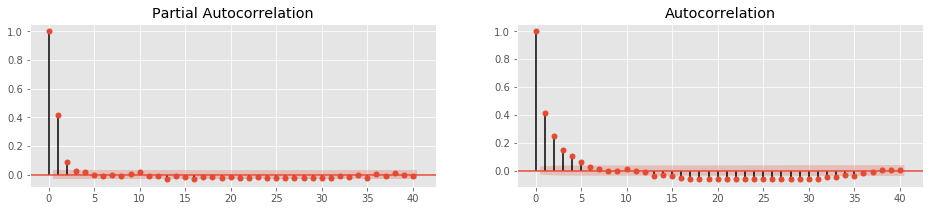

In [10]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_train.Actual, lags=40, ax=axes[0])
plot_acf(df_train.Actual,lags=40, ax=axes[ 1])

plt.show()

In [19]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_train, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 4368
Model:                     ARMA(1, 1)   Log Likelihood              -20973.264
Method:                       css-mle   S.D. of innovations             29.448
Date:                Wed, 19 Aug 2020   AIC                          41954.528
Time:                        20:33:04   BIC                          41980.056
Sample:                    12-23-2019   HQIC                         41963.536
                         - 03-22-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.1563      0.862      9.466      0.000       6.468       9.845
ar.L1.Actual     0.5990      0.029     21.015      0.000       0.543       0.655
ma.L1.Actual    -0.2243      0.035     -6.43

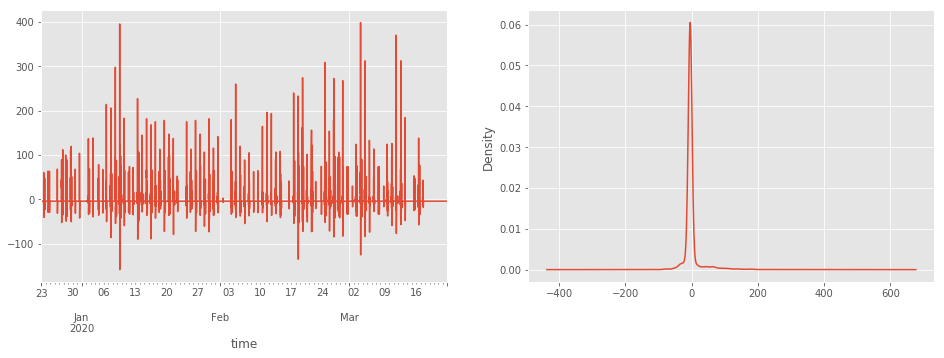

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit.resid.plot(ax=axes[0])
model_fit.resid.plot(kind='kde', ax=axes[1])

In [21]:
# predict the model
predict_train= model_fit.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)

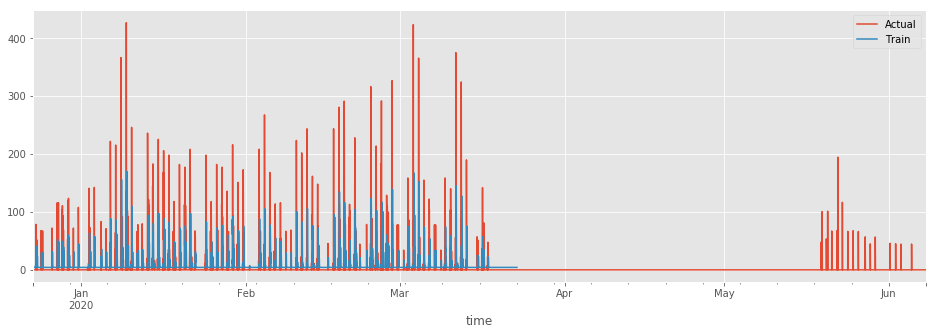

In [22]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[3:int(subset_num*size+3)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):subset_num+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([df_half, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all.set_index(df_all.index).plot(figsize=(16,5))

In [23]:
# next hour prediction
next_halfhour=model_fit.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',df_half['Actual'][4368:4369])

Pred:  [4.21656949] Std:  [29.44750265] Confidence:  [[-53.49947513  61.93261412]]
Actual:  time
2020-03-23    0.0
Freq: 30T, Name: Actual, dtype: float64


In [24]:
mae = np.mean(np.abs(df_all['Train'][:4368] - df_all['Actual'][:4368]))
rmse = np.mean((df_all['Train'][:4368] - df_all['Actual'][:4368])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  13.618502738104583 RMSE:  33.992060794741136


## decom

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose seasonal 
decom = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=336)
#decom1 = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=48)
deseason = df_half.Actual.values - decom.seasonal 
deseason = pd.DataFrame(deseason)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
deseason.rename(columns=({'seasonal':'Actual'}),inplace=True)
deseason

,Actual
time,
2019-12-23 00:00:00,4.754358
2019-12-23 00:30:00,4.754305
2019-12-23 01:00:00,4.754136
2019-12-23 01:30:00,4.749490
2019-12-23 02:00:00,4.744901
...,...
2020-06-07 21:30:00,4.510910
2020-06-07 22:00:00,4.510978
2020-06-07 22:30:00,4.510931


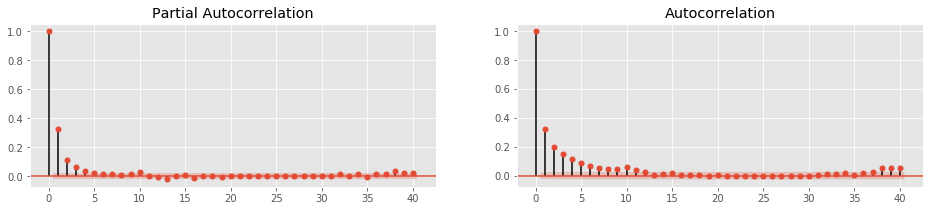

In [27]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(deseason.Actual, lags=40, ax=axes[0])
plot_acf(deseason.Actual,lags=40, ax=axes[ 1])

plt.show()

In [28]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(deseason.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -35.664686
p-value: 0.000000
Critial Values:
   1%, -4.372568293943763
Critial Values:
   5%, -3.833122909609003
Critial Values:
   10%, -3.553714126262795


In [29]:
# subset  dataset for train 
subset_num = 4368
df_train_test = deseason[['Actual']][:subset_num]
df_simul = deseason[['Actual']][subset_num:]

In [30]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

4368 0


In [43]:
#train 
model0 = ARIMA(df_train, order=(1,1,2))
model_fit0 = model0.fit(disp=0)
print(model_fit0.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Actual   No. Observations:                 4367
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -20201.649
Method:                       css-mle   S.D. of innovations             24.694
Date:                Wed, 19 Aug 2020   AIC                          40413.298
Time:                        20:37:30   BIC                          40445.207
Sample:                    12-23-2019   HQIC                         40424.558
                         - 03-22-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0004      0.002     -0.169      0.866      -0.005       0.004
ar.L1.D.Actual     0.6358      0.046     13.807      0.000       0.546       0.726
ma.L1.D.Actual    -1.4410      0.053

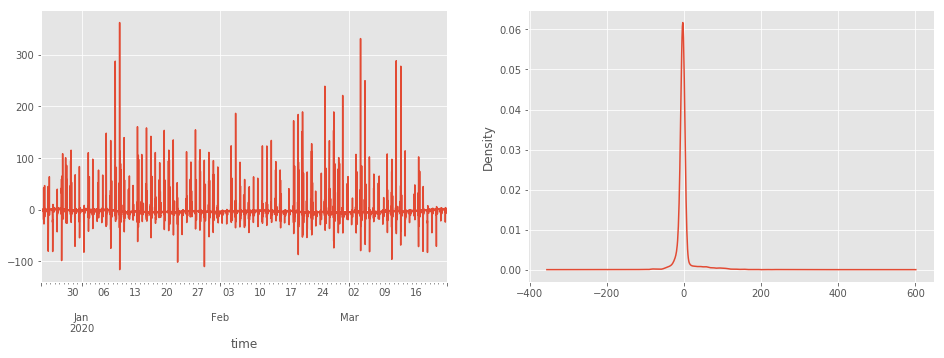

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit0.resid.plot(ax=axes[0])
model_fit0.resid.plot(kind='kde', ax=axes[1])

In [45]:
# predict the model
predict_train= model_fit0.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)

In [46]:
deseason_diff=deseason.diff()

Text(0, 0.5, 'Wh')

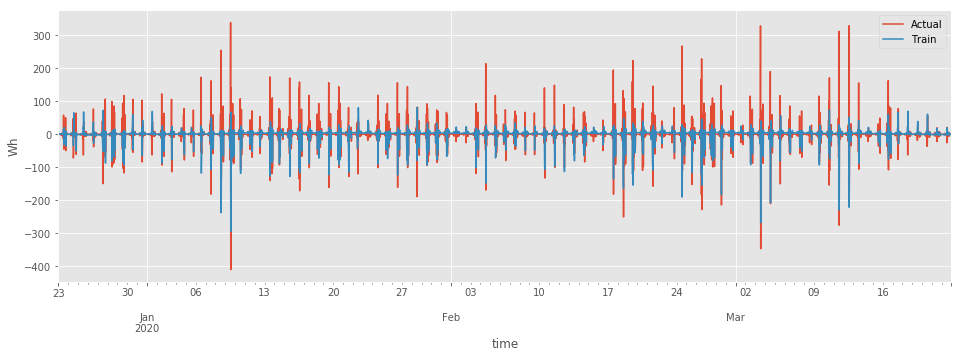

In [57]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[1:int(subset_num*size)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):subset_num+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([deseason_diff, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all[:4368].set_index(df_all[:4368].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [51]:
# next hour prediction
next_halfhour=model_fit0.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',deseason['Actual'][4368:4369])

Pred:  [3.32885663] Std:  [24.69431899] Confidence:  [[-45.07111922  51.72883248]]
Actual:  time
2020-03-23    4.754358
Freq: 30T, Name: Actual, dtype: float64


In [53]:
mae = np.mean(np.abs(df_all['Actual'][:subset_num] - df_all['Train'][:subset_num]))
rmse = np.mean((df_all['Actual'][:subset_num] - df_all['Train'][:subset_num])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  9.897498916684562 RMSE:  24.69665964478255


In [55]:
df_all['Actual'][:subset_num].mean()

-5.576431367971345e-05

In [61]:
# with lockdown
mad_mean_ratio =9.897*4368/(df_all['Actual'][:4368]).sum() 
mad_mean_ratio

-177519.73730763304